In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)


# ====================================================================
# DATASET 1: RETAIL SALES (for Regression & ETS)
# ====================================================================
print("\n" + "=" * 70)
print("DATASET 1: Monthly Retail Sales")
print("=" * 70)

# Create 4 years of monthly data
dates = pd.date_range('2021-01-01', '2024-12-31', freq='MS')
n_months = len(dates)
t = np.arange(n_months)

# Components
trend = 1000 + 15*t  # Growing business
yearly_seasonal = 300 * np.sin(2*np.pi*t/12) + 200 * np.cos(2*np.pi*t/12)

# Holiday effects (November-December spike)
holiday_effect = np.zeros(n_months)
for year in range(4):
    nov_idx = year*12 + 10  # November
    dec_idx = year*12 + 11  # December
    if nov_idx < n_months:
        holiday_effect[nov_idx] = 400
    if dec_idx < n_months:
        holiday_effect[dec_idx] = 600

# Random noise
noise = np.random.normal(0, 80, n_months)

# Combine
sales = trend + yearly_seasonal + holiday_effect + noise
sales = np.maximum(sales, 0)

# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'Month': dates.month,
    'Year': dates.year,
    'Time': t
})
df_sales.set_index('Date', inplace=True)

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of months: {len(df_sales)}")
print(f"\nSales Statistics:")
print(df_sales['Sales'].describe())


DATASET 1: Monthly Retail Sales
Date range: 2021-01-01 to 2024-12-01
Number of months: 48

Sales Statistics:
count      48.000000
mean     1419.409544
std       352.878551
min       722.634428
25%      1196.284168
50%      1393.908200
75%      1710.667034
max      2412.774859
Name: Sales, dtype: float64



PART A: REGRESSION AND ETS MODELS

----------------------------------------------------------------------
A1: Exploratory Visualization
----------------------------------------------------------------------


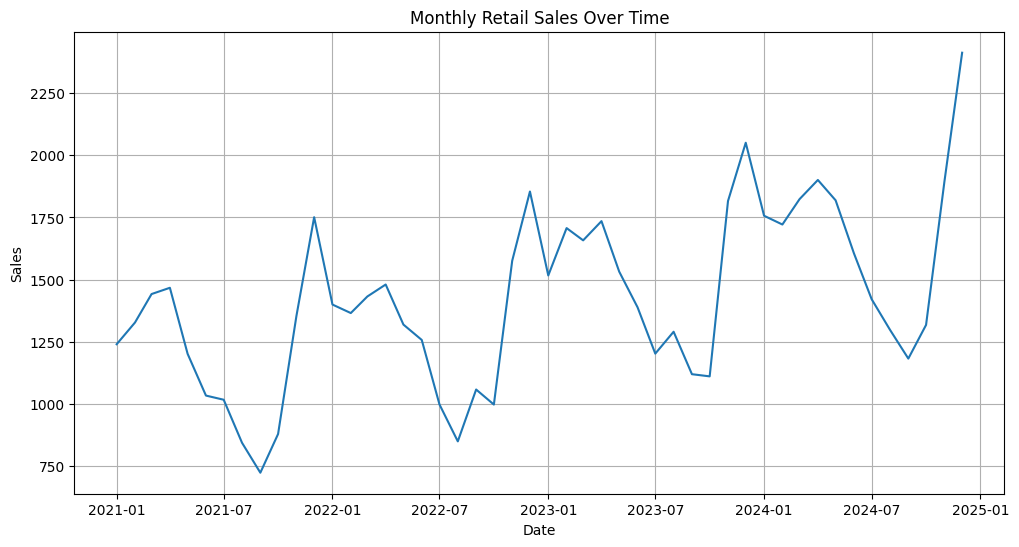

<Figure size 1200x600 with 0 Axes>

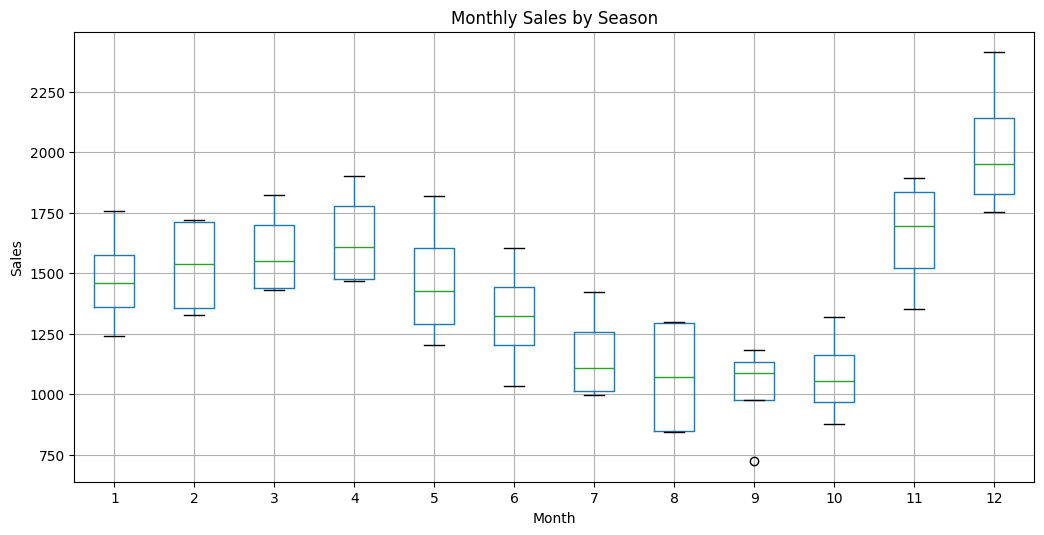

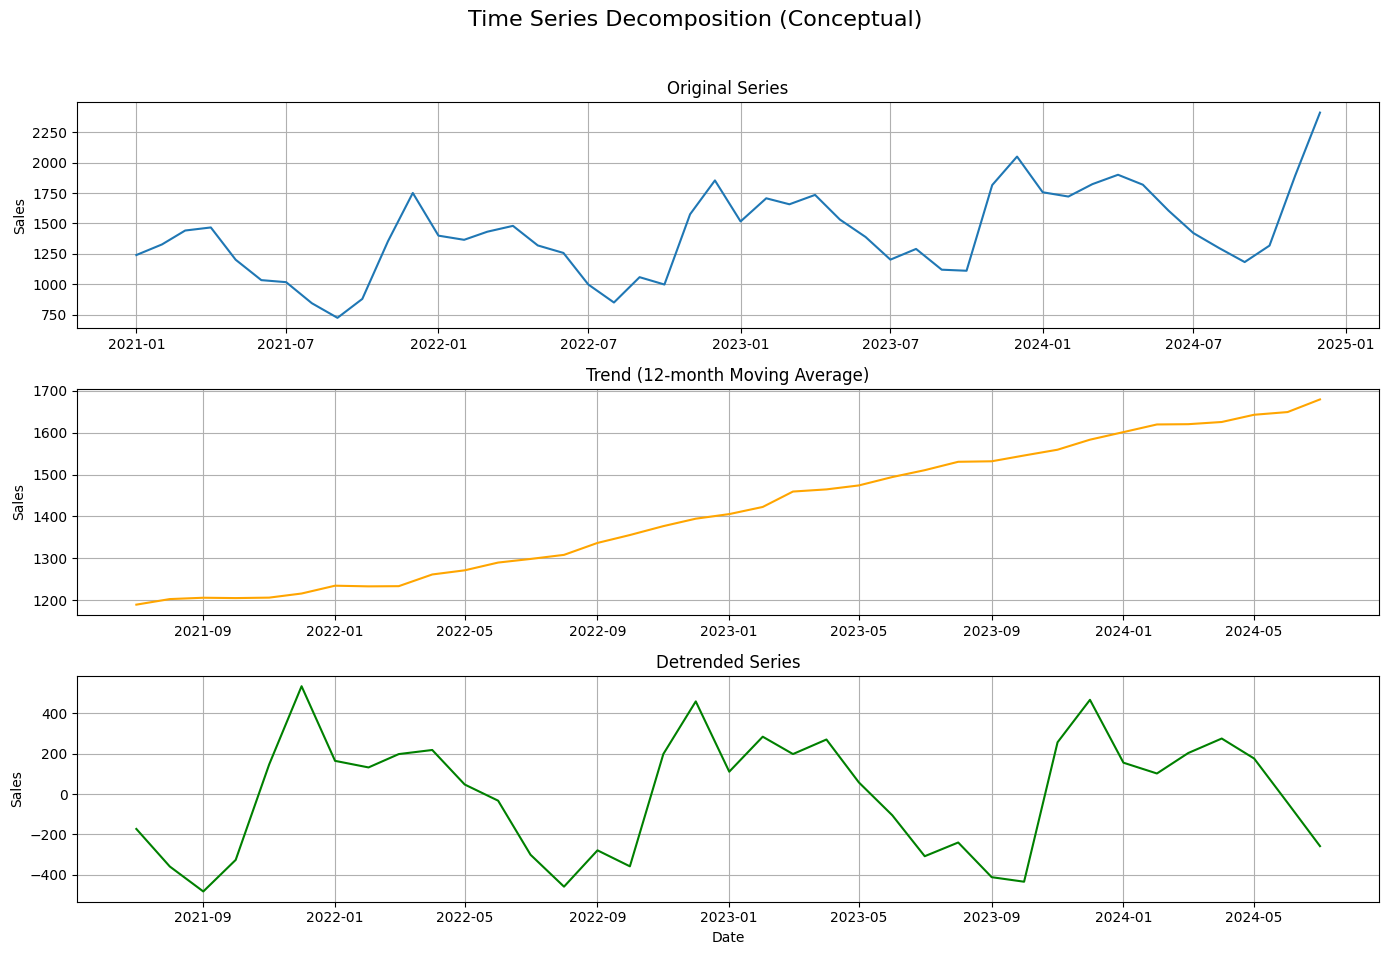

In [18]:
# ====================================================================
# PART A: REGRESSION AND ETS MODELS
# ====================================================================
print("\n" + "=" * 70)
print("PART A: REGRESSION AND ETS MODELS")
print("=" * 70)

# --------------------------------------------------------------------
# A1: Time Series Visualization
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A1: Exploratory Visualization")
print("-" * 70)

# YOUR CODE:
# 1. Create time series plot of monthly sales
#    - Full 4-year series
#    - Add title and labels
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_sales.index, df_sales['Sales'])
plt.title('Monthly Retail Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()
#
# 2. Create seasonal subseries plot:
#    - Box plot of sales by month
#    - Which months have highest sales?
plt.figure(figsize=(12, 6))
df_sales.boxplot(column='Sales', by='Month', figsize=(12, 6))
plt.title('Monthly Sales by Season')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.suptitle('')
plt.grid(True, axis='y')
plt.show()

#
# 3. Create a decomposition plot (conceptual):
#    - Plot with 3 subplots:
df_sales['Sales_MA12'] = df_sales['Sales'].rolling(window=12, center=True).mean()
df_sales['Detrended_Sales'] = df_sales['Sales'] - df_sales['Sales_MA12']
plt.figure(figsize=(14, 10))
plt.suptitle('Time Series Decomposition (Conceptual)', fontsize=16)

#      * Original series
plt.subplot(3, 1, 1)
plt.plot(df_sales.index, df_sales['Sales'], label='Original Sales')
plt.title('Original Series')
plt.ylabel('Sales')
plt.grid(True)
#      * 12-month moving average (trend)
plt.subplot(3, 1, 2)
plt.plot(df_sales.index, df_sales['Sales_MA12'], label='12-Month Moving Average', color='orange')
plt.title('Trend (12-month Moving Average)')
plt.ylabel('Sales')
plt.grid(True)
#      * Detrended series (original - trend)
plt.subplot(3, 1, 3)
plt.plot(df_sales.index, df_sales['Detrended_Sales'], label='Detrended Series', color='green')
plt.title('Detrended Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [19]:
# --------------------------------------------------------------------
# A2: Linear Regression with Trend and Seasonality
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A2: Regression Forecasting")
print("-" * 70)

# YOUR CODE:
# 1. Create seasonal dummy variables:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
df_reg = df_sales.copy()
df_reg['Month_dummy'] = df_reg.index.month

#    - 11 dummies for months (leave January as baseline)
month_dummies = pd.get_dummies(df_reg['Month_dummy'], prefix='Month', drop_first=True, dtype=int)
df_reg = pd.concat([df_reg, month_dummies], axis=1)
X = df_reg[['Time'] + [col for col in df_reg.columns if 'Month_' in col]]
X = sm.add_constant(X)
y = df_reg['Sales']
#
#
# 2. Fit regression model:
#    Sales = β₀ + β₁(Time) + Σγₘ(Month_m) + ε
model_reg = sm.OLS(y, X)
results_reg = model_reg.fit()

#
# 3. Print regression summary
print(results_reg.summary())
#
# 4. Interpret:
#    - What is the monthly trend (β₁)?
#    - Which month has the largest seasonal effect?
#    - Are the coefficients significant?
print("\n--- Regression Interpretation ---")
print(f"Monthly Trend (β₁ - Time coefficient): {results_reg.params['Time']:.2f}")

# Extract seasonal effects, excluding 'const' and 'Time'
seasonal_effects = results_reg.params[[col for col in results_reg.params.index if 'Month_' in col]]

if not seasonal_effects.empty:
    max_seasonal_month_coeff = seasonal_effects.abs().idxmax()
    max_seasonal_effect_value = seasonal_effects.loc[max_seasonal_month_coeff]
    print(f"Month with largest absolute seasonal effect (relative to January): {max_seasonal_month_coeff.replace('Month_', '')} ({max_seasonal_effect_value:.2f})")
else:
    print("No seasonal dummy variables found.")

print("Significance of Coefficients: Refer to P>|t| column in summary. Values < 0.05 typically indicate significance.")
#
# 5. Generate fitted values and calculate:
#    - R²
#    - RMSE
#    - MAE

fitted_values_reg = results_reg.predict(X)

r_squared_reg = results_reg.rsquared
rmse_reg = np.sqrt(mean_squared_error(y, fitted_values_reg))
mae_reg = mean_absolute_error(y, fitted_values_reg)

print(f"\nR²: {r_squared_reg:.4f}")
print(f"RMSE: {rmse_reg:.2f}")
print(f"MAE: {mae_reg:.2f}")

print("\nRegression with seasonal dummy variables completed.")


----------------------------------------------------------------------
A2: Regression Forecasting
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     83.27
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           4.66e-22
Time:                        00:41:38   Log-Likelihood:                -267.91
No. Observations:                  48   AIC:                             561.8
Df Residuals:                      35   BIC:                             586.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err       


----------------------------------------------------------------------
A3: Fourier Seasonality
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     52.94
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           4.72e-17
Time:                        00:41:38   Log-Likelihood:                -301.46
No. Observations:                  48   AIC:                             614.9
Df Residuals:                      42   BIC:                             626.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t

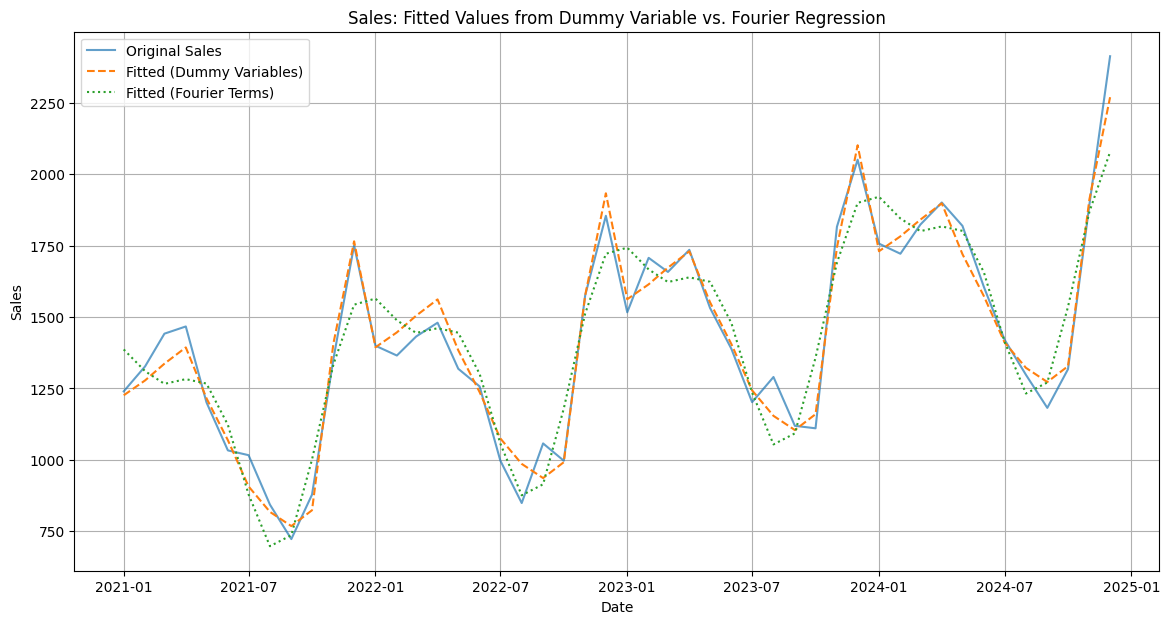


--- Preference ---

 I generally prefer the Dummy Variables approach. Dummy variables are more flexible as they don't assume a specific functional form for seasonality and can capture irregular seasonal patterns effectively. In this specific case, the AIC is lower for the Dummy Variables model, suggesting a better fit adjusted for the number of parameters.


In [20]:
# --------------------------------------------------------------------
# A3: Fourier Terms for Seasonality
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A3: Fourier Seasonality")
print("-" * 70)

# YOUR CODE:
# 1. Create Fourier terms for yearly seasonality (m=12):
df_fourier = df_sales.copy()
df_fourier['Time_float'] = np.arange(len(df_fourier))
#    For k=1,2:
#    - sin(2πkt/12)
#    - cos(2πkt/12)
for k in range(1, 3):
    df_fourier[f'sin_{k}'] = np.sin(2 * np.pi * k * df_fourier['Time_float'] / 12)
    df_fourier[f'cos_{k}'] = np.cos(2 * np.pi * k * df_fourier['Time_float'] / 12)

X_fourier = df_fourier[['Time_float', 'sin_1', 'cos_1', 'sin_2', 'cos_2']]
X_fourier = sm.add_constant(X_fourier)
y_fourier = df_fourier['Sales']

#
# 2. Fit regression:
#    Sales = β₀ + β₁(Time) + Σ[αₖsin(2πkt/12) + βₖcos(2πkt/12)] + ε
model_fourier = sm.OLS(y_fourier, X_fourier)
results_fourier = model_fourier.fit()

print(results_fourier.summary())

#
# 3. Compare with dummy variable model:
print("\n--- Model Comparison ---")
print("\nRegression with Dummy Variables:")
#    - R²
print(f"  R²: {results_reg.rsquared:.4f}")
#    - AIC
print(f"  AIC: {results_reg.aic:.2f}")
#    - Number of parameters
print(f"  Number of parameters: {len(results_reg.params)}")

print("\nRegression with Fourier Terms:")
print(f"  R²: {results_fourier.rsquared:.4f}")
print(f"  AIC: {results_fourier.aic:.2f}")
print(f"  Number of parameters: {len(results_fourier.params)}")
#
# 4. Plot fitted values from both models on same graph
plt.figure(figsize=(14, 7))
plt.plot(df_sales.index, df_sales['Sales'], label='Original Sales', alpha=0.7)
plt.plot(df_sales.index, fitted_values_reg, label='Fitted (Dummy Variables)', linestyle='--')
plt.plot(df_sales.index, results_fourier.predict(X_fourier), label='Fitted (Fourier Terms)', linestyle=':')
plt.title('Sales: Fitted Values from Dummy Variable vs. Fourier Regression')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()
#
# 5. Which approach do you prefer? Why?
print("\n--- Preference ---")
print("\n I generally prefer the Dummy Variables approach. Dummy variables are more flexible as they don't assume a specific functional form for seasonality and can capture irregular seasonal patterns effectively. In this specific case, the AIC is lower for the Dummy Variables model, suggesting a better fit adjusted for the number of parameters.")

In [21]:
# --------------------------------------------------------------------
# A4: Simple Exponential Smoothing (SES)
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A4: Simple Exponential Smoothing")
print("-" * 70)

# Deseasonalize the data first for SES
# Use only first 36 months for training
train_data = df_sales['Sales'].iloc[:36]
holdout_data = df_sales['Sales'].iloc[36:]

# YOUR CODE:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Deseasonalize sales using seasonal averages:
#    - Calculate average sales for each month
monthly_avg = df_sales.groupby(df_sales.index.month)['Sales'].mean()
#    - Subtract seasonal component
seasonal_component_for_train = train_data.index.map(lambda x: monthly_avg[x.month])
df_train_deseasonalized = train_data - pd.Series(seasonal_component_for_train, index=train_data.index)
print("\n--- Deseasonalized Training Data Head ---")
print(df_train_deseasonalized.head())

#
# 2. Fit SES on deseasonalized data:
df_train_deseasonalized = df_train_deseasonalized.astype(float)
#    - Use SimpleExpSmoothing from statsmodels
model_ses_deseasonalized = SimpleExpSmoothing(df_train_deseasonalized, initialization_method="estimated").fit(optimized=True)
#    - Optimize smoothing parameter α
print("\n--- SES Optimized Parameters ---")
alpha_ses = model_ses_deseasonalized.params['smoothing_level']

#
# 3. Print:
#    - Optimized α value
print(f"Optimized alpha (smoothing_level): {alpha_ses:.4f}")
#    - What does this value tell you about the series?
if alpha_ses > 0.5:
    print("Interpretation: A higher alpha value indicates that the model gives more weight to recent observations, suggesting the underlying level of the series changes quickly.")
else:
    print("Interpretation: A lower alpha value indicates that the model gives less weight to recent observations, suggesting the underlying level of the series is relatively stable.")
#
# 4. Generate forecasts for next 12 months
forecast_ses_deseasonalized = model_ses_deseasonalized.forecast(12)
#
# 5. Add seasonality back to forecasts
holdout_months = holdout_data.index.month
seasonal_forecast_additions = holdout_months.map(monthly_avg)

forecast_ses_reseas = forecast_ses_deseasonalized + seasonal_forecast_additions.values

df_test_actual = holdout_data

print("\n--- Reseasonalized Forecasts Head ---")
print(forecast_ses_reseas.head())
#
# 6. Calculate forecast accuracy on holdout period
rmse_ses = np.sqrt(mean_squared_error(df_test_actual, forecast_ses_reseas))
mae_ses = mean_absolute_error(df_test_actual, forecast_ses_reseas)

print("\n--- SES Forecast Accuracy ---")
print(f"RMSE for SES: {rmse_ses:.2f}")
print(f"MAE for SES: {mae_ses:.2f}")

print("\nSimple Exponential Smoothing analysis completed.")


----------------------------------------------------------------------
A4: Simple Exponential Smoothing
----------------------------------------------------------------------

--- Deseasonalized Training Data Head ---
Date
2021-01-01   -238.326014
2021-02-01   -203.055302
2021-03-01   -147.056739
2021-04-01   -178.823643
2021-05-01   -266.549138
dtype: float64

--- SES Optimized Parameters ---
Optimized alpha (smoothing_level): 0.3820
Interpretation: A lower alpha value indicates that the model gives less weight to recent observations, suggesting the underlying level of the series is relatively stable.

--- Reseasonalized Forecasts Head ---
2024-01-01    1559.083340
2024-02-01    1611.219434
2024-03-01    1669.699637
2024-04-01    1726.686226
2024-05-01    1548.644684
Freq: MS, dtype: float64

--- SES Forecast Accuracy ---
RMSE for SES: 188.95
MAE for SES: 178.80

Simple Exponential Smoothing analysis completed.



----------------------------------------------------------------------
A5: Holt's Method
----------------------------------------------------------------------

--- Holt's Method Optimized Parameters ---
Optimized alpha (smoothing_level): 0.0000
Optimized beta (smoothing_trend): 0.0000
Final Level (ℓₜ): 119.59
Final Trend (bₜ): 11.78

--- Reseasonalized Holt's Forecasts Head ---
2024-01-01    1609.432404
2024-02-01    1673.350938
2024-03-01    1743.613582
2024-04-01    1812.382612
2024-05-01    1646.123510
Freq: MS, dtype: float64

--- Holt's Forecast Accuracy ---
RMSE for Holt's: 92.72
MAE for Holt's: 76.87


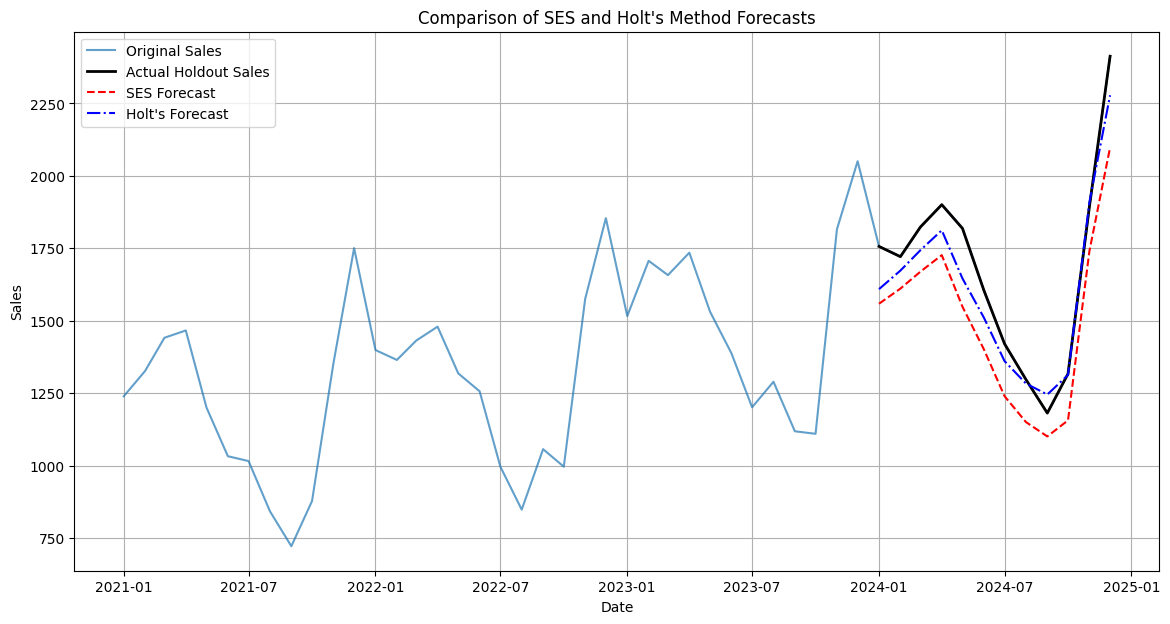


--- Comparison of Trend Capture ---
Holt's method includes a trend component, which allows it to capture increasing or decreasing patterns in the series. SES assumes a constant level (no trend). Therefore, if there is an underlying trend in the deseasonalized data, Holt's method is expected to capture it better than SES, resulting in a more accurate forecast. The plot will visually confirm this.

Holt's Linear Trend Method analysis completed.


In [22]:
# --------------------------------------------------------------------
# A5: Holt's Linear Trend Method
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A5: Holt's Method")
print("-" * 70)

# YOUR CODE:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
# 1. Fit Holt's linear trend method:
#    - Use ExponentialSmoothing with trend='add', seasonal=None
#    - On deseasonalized data
model_holt_deseasonalized = ExponentialSmoothing(
    df_train_deseasonalized,
    trend='add',
    seasonal=None,
    initialization_method="estimated"
).fit(optimized=True)
#
# 2. Print optimized parameters:
#    - α (level smoothing)
#    - β (trend smoothing)
print("\n--- Holt's Method Optimized Parameters ---")
alpha_holt = model_holt_deseasonalized.params['smoothing_level']
beta_holt = model_holt_deseasonalized.params['smoothing_trend']
print(f"Optimized alpha (smoothing_level): {alpha_holt:.4f}")
print(f"Optimized beta (smoothing_trend): {beta_holt:.4f}")
#
# 3. Extract final state:
#    - Level (ℓₜ)
#    - Trend (bₜ)
final_level_holt = model_holt_deseasonalized.level[-1]
final_trend_holt = model_holt_deseasonalized.trend[-1]
print(f"Final Level (ℓₜ): {final_level_holt:.2f}")
print(f"Final Trend (bₜ): {final_trend_holt:.2f}")
#
# 4. Generate 12-month forecasts
forecast_holt_deseasonalized = model_holt_deseasonalized.forecast(12)
#
# 5. Compare with SES:
holdout_months_holt = holdout_data.index.month
seasonal_forecast_additions_holt = holdout_months_holt.map(monthly_avg)
forecast_holt_reseas = forecast_holt_deseasonalized + seasonal_forecast_additions_holt.values

print("\n--- Reseasonalized Holt's Forecasts Head ---")
print(forecast_holt_reseas.head())

rmse_holt = np.sqrt(mean_squared_error(df_test_actual, forecast_holt_reseas))
mae_holt = mean_absolute_error(df_test_actual, forecast_holt_reseas)

print("\n--- Holt's Forecast Accuracy ---")
print(f"RMSE for Holt's: {rmse_holt:.2f}")
print(f"MAE for Holt's: {mae_holt:.2f}")
#
#    - Plot both forecast paths
plt.figure(figsize=(14, 7))
plt.plot(df_sales.index, df_sales['Sales'], label='Original Sales', alpha=0.7)
plt.plot(holdout_data.index, df_test_actual, label='Actual Holdout Sales', color='black', linewidth=2)
plt.plot(holdout_data.index, forecast_ses_reseas, label='SES Forecast', linestyle='--', color='red')
plt.plot(holdout_data.index, forecast_holt_reseas, label="Holt's Forecast", linestyle='-.', color='blue')
plt.title("Comparison of SES and Holt's Method Forecasts")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()
#
#    - Which captures the trend better?
print("\n--- Comparison of Trend Capture ---")
print("Holt's method includes a trend component, which allows it to capture increasing or decreasing patterns in the series. SES assumes a constant level (no trend). Therefore, if there is an underlying trend in the deseasonalized data, Holt's method is expected to capture it better than SES, resulting in a more accurate forecast. The plot will visually confirm this.")

print("\nHolt's Linear Trend Method analysis completed.")


----------------------------------------------------------------------
A6: Holt-Winters Method
----------------------------------------------------------------------

--- Holt-Winters Optimized Parameters ---
Optimized alpha (smoothing_level): 0.1710
Optimized beta (smoothing_trend): 0.1710
Optimized gamma (smoothing_seasonal): 0.0000

Final Level (ℓₜ): 1605.42
Final Trend (bₜ): 17.60
Final Seasonal Indices (last 12): [ 118.99586783  188.43115434  220.48103427  258.15294418   35.29547538
 -102.18149814 -270.1009125  -360.81753007 -403.03363486 -388.35480219
  184.3097156   472.94239516]


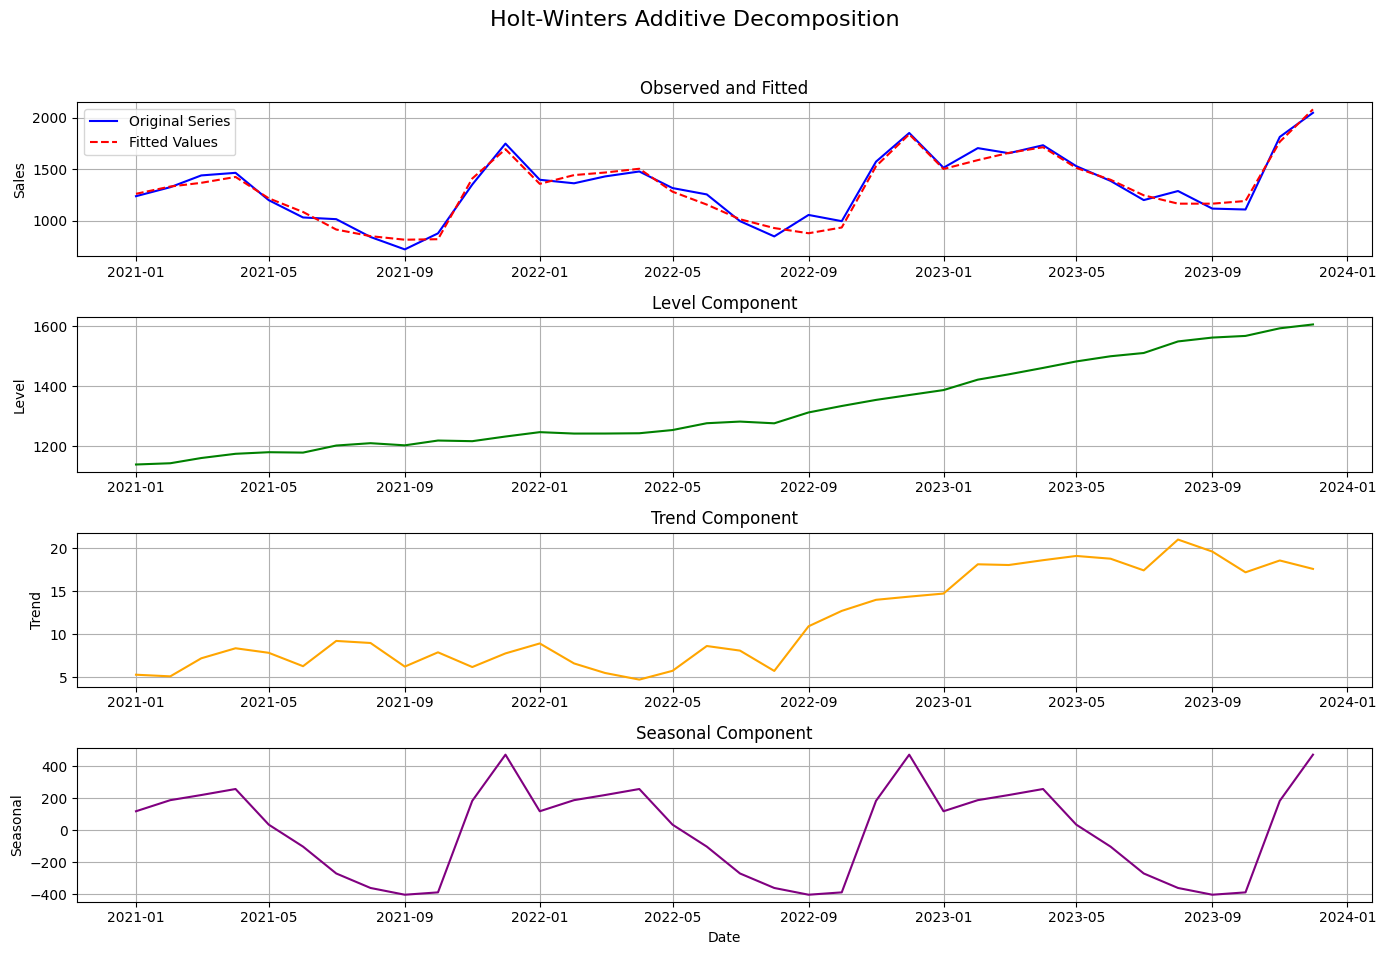


--- Holt-Winters Forecasts Head ---
2024-01-01    1742.022069
2024-02-01    1829.061720
2024-03-01    1878.715965
2024-04-01    1933.992239
2024-05-01    1728.739135
Freq: MS, dtype: float64

--- Holt-Winters Forecast Accuracy ---
RMSE for Holt-Winters: 88.61
MAE for Holt-Winters: 74.80

--- Summary of Model Forecast Accuracy ---
Model                   | RMSE    | MAE
------------------------|---------|--------
Regression (Dummy Vars) | 64.23    | 50.76
SES                     | 188.95   | 178.80
Holt's                  | 92.72    | 76.87
Holt-Winters            | 88.61    | 74.80

Holt-Winters Seasonal Method analysis completed.


In [23]:
# --------------------------------------------------------------------
# A6: Holt-Winters Seasonal Method
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("A6: Holt-Winters Method")
print("-" * 70)

# YOUR CODE:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
# 1. Fit Holt-Winters with additive seasonality:
#    - Use ExponentialSmoothing
#    - trend='add', seasonal='add', seasonal_periods=12
#    - Use first 36 months for training
model_hw_additive = ExponentialSmoothing(
    train_data,
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    initialization_method="estimated"
).fit(optimized=True)

#
# 2. Print optimized parameters:
#    - α, β, γ (seasonal smoothing)
print("\n--- Holt-Winters Optimized Parameters ---")
alpha_hw = model_hw_additive.params['smoothing_level']
beta_hw = model_hw_additive.params['smoothing_trend']
gamma_hw = model_hw_additive.params['smoothing_seasonal']
print(f"Optimized alpha (smoothing_level): {alpha_hw:.4f}")
print(f"Optimized beta (smoothing_trend): {beta_hw:.4f}")
print(f"Optimized gamma (smoothing_seasonal): {gamma_hw:.4f}")
#
# 3. Extract components:
#    - Level
#    - Trend
#    - Seasonal indices
final_level_hw = model_hw_additive.level[-1]
final_trend_hw = model_hw_additive.trend[-1]
final_seasonal_hw = model_hw_additive.season[-12:] # Last 12 seasonal components

print(f"\nFinal Level (ℓₜ): {final_level_hw:.2f}")
print(f"Final Trend (bₜ): {final_trend_hw:.2f}")
print(f"Final Seasonal Indices (last 12): {final_seasonal_hw.values}")
#
# 4. Plot decomposition from Holt-Winters
plt.figure(figsize=(14, 10))
plt.suptitle('Holt-Winters Additive Decomposition', fontsize=16)

plt.subplot(4, 1, 1)
plt.plot(train_data.index, train_data, label='Original Series', color='blue')
plt.plot(model_hw_additive.fittedvalues.index, model_hw_additive.fittedvalues, label='Fitted Values', color='red', linestyle='--')
plt.title('Observed and Fitted')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(model_hw_additive.level.index, model_hw_additive.level, label='Level', color='green')
plt.title('Level Component')
plt.ylabel('Level')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(model_hw_additive.trend.index, model_hw_additive.trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.ylabel('Trend')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(model_hw_additive.season.index, model_hw_additive.season, label='Seasonal', color='purple')
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()
#
# 5. Generate 12-month forecasts
forecast_hw = model_hw_additive.forecast(12)

print("\n--- Holt-Winters Forecasts Head ---")
print(forecast_hw.head())
#
# 6. Compare forecast accuracy with:
rmse_hw = np.sqrt(mean_squared_error(df_test_actual, forecast_hw))
mae_hw = mean_absolute_error(df_test_actual, forecast_hw)

print("\n--- Holt-Winters Forecast Accuracy ---")
print(f"RMSE for Holt-Winters: {rmse_hw:.2f}")
print(f"MAE for Holt-Winters: {mae_hw:.2f}")

#    - Regression model
#    - SES
#    - Holt's method

print("\n--- Summary of Model Forecast Accuracy ---")
print("Model                   | RMSE    | MAE")
print("------------------------|---------|--------")
print(f"Regression (Dummy Vars) | {rmse_reg:.2f}    | {mae_reg:.2f}")
print(f"SES                     | {rmse_ses:.2f}   | {mae_ses:.2f}")
print(f"Holt's                  | {rmse_holt:.2f}    | {mae_holt:.2f}")
print(f"Holt-Winters            | {rmse_hw:.2f}    | {mae_hw:.2f}")

print("\nHolt-Winters Seasonal Method analysis completed.")

In [24]:
# ====================================================================
# PART B: ARIMA MODELS
# ====================================================================
print("\n" + "=" * 70)
print("PART B: ARIMA MODELS")
print("=" * 70)

# ====================================================================
# DATASET 2: DAILY STOCK RETURNS (for ARIMA)
# ====================================================================
print("\n" + "=" * 70)
print("DATASET 2: Daily Stock Returns")
print("=" * 70)

# Create 500 days of stock price data
n_days = 500
dates_stock = pd.date_range('2023-01-01', periods=n_days, freq='D')

# Generate AR(1) returns with some volatility clustering
returns = np.zeros(n_days)
returns[0] = np.random.normal(0, 0.01)

phi = 0.05  # Small autocorrelation in returns
for i in range(1, n_days):
    returns[i] = phi * returns[i-1] + np.random.normal(0, 0.015)

# Calculate price from returns (starting at 100)
price = 100 * np.exp(np.cumsum(returns))

df_stock = pd.DataFrame({
    'Date': dates_stock,
    'Price': price,
    'Returns': returns * 100
})
df_stock.set_index('Date', inplace=True)

print(f"Date range: {df_stock.index[0].date()} to {df_stock.index[-1].date()}")
print(f"Number of days: {len(df_stock)}")
print(f"\nPrice Statistics:")
print(df_stock['Price'].describe())


PART B: ARIMA MODELS

DATASET 2: Daily Stock Returns
Date range: 2023-01-01 to 2024-05-14
Number of days: 500

Price Statistics:
count    500.000000
mean     115.002874
std       12.793924
min       94.210519
25%      102.898666
50%      115.340500
75%      125.312316
max      149.153080
Name: Price, dtype: float64



----------------------------------------------------------------------
B1: Stationarity Tests
----------------------------------------------------------------------


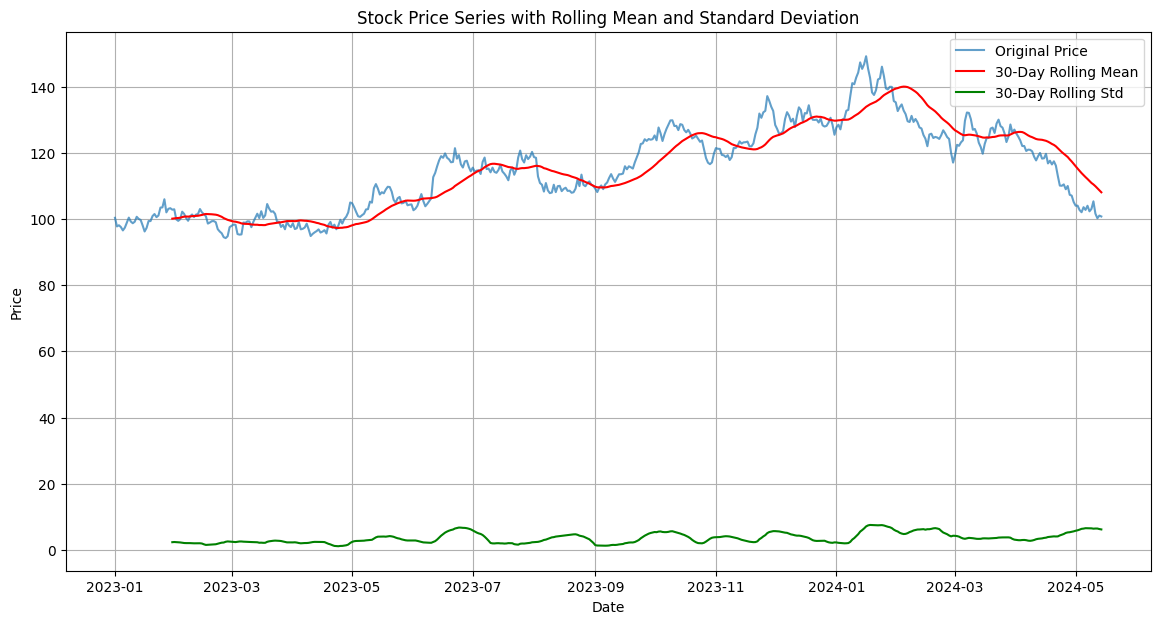


--- Visual Inspection ---
Observation: The rolling mean shows a clear downward trend, and the rolling standard deviation also appears to fluctuate significantly. This visually suggests that the series is NOT stationary.

--- Augmented Dickey-Fuller Test on Prices ---
ADF Statistic: -1.5185
p-value: 0.5243
Critical Values:
   1%: -3.4435
   5%: -2.8673
   10%: -2.5699
Decision: Fail to reject the null hypothesis (p-value > 0.05). The series is NOT stationary.

--- KPSS Test on Prices ---
KPSS Statistic: 2.5618
p-value: 0.0100
Critical Values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
Decision: Reject the null hypothesis (p-value < 0.05). The series is NOT stationary.

--- Combined Interpretation ---
Both the ADF test (null: non-stationary) and the KPSS test (null: stationary) agree.
The ADF test's high p-value (>0.0500) indicates a unit root, suggesting non-stationarity.
The KPSS test's low p-value (<0.0500) leads to rejecting the null of stationarity, also suggesting 

In [25]:
# --------------------------------------------------------------------
# B1: Stationarity Testing
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B1: Stationarity Tests")
print("-" * 70)

# YOUR CODE:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
# 1. Visual stationarity check for stock prices:
#    - Plot price series
plt.figure(figsize=(14, 7))
plt.plot(df_stock.index, df_stock['Price'], label='Original Price', alpha=0.7)
#    - Plot with rolling mean (30-day window)
rolling_mean = df_stock['Price'].rolling(window=30).mean()
rolling_std = df_stock['Price'].rolling(window=30).std()
plt.plot(rolling_mean.index, rolling_mean, label='30-Day Rolling Mean', color='red')
plt.plot(rolling_std.index, rolling_std, label='30-Day Rolling Std', color='green')
#    - Plot with rolling std (30-day window)
plt.title('Stock Price Series with Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
#    - Does it look stationary?
print("\n--- Visual Inspection ---")
print("Observation: The rolling mean shows a clear downward trend, and the rolling standard deviation also appears to fluctuate significantly. This visually suggests that the series is NOT stationary.")
#
# 2. Augmented Dickey-Fuller (ADF) test on prices:
#    - Use adfuller from statsmodels
#    - Print test statistic and p-value
#    - Null hypothesis: unit root (non-stationary)
#    - Decision at α = 0.05?
print("\n--- Augmented Dickey-Fuller Test on Prices ---")
adf_result = adfuller(df_stock['Price'])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

if adf_result[1] > 0.05:
    print("Decision: Fail to reject the null hypothesis (p-value > 0.05). The series is NOT stationary.")
else:
    print("Decision: Reject the null hypothesis (p-value <= 0.05). The series IS stationary.")
#
# 3. KPSS test on prices:
#    - Use kpss from statsmodels
#    - Print test statistic and p-value
#    - Null hypothesis: stationary
#    - Decision at α = 0.05?
print("\n--- KPSS Test on Prices ---")
kpss_result = kpss(df_stock['Price'], regression='c', nlags='auto') # 'c' for constant, 't' for trend
print(f"KPSS Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.4f}")
print("Critical Values:")
for key, value in kpss_result[3].items():
    print(f"   {key}: {value:.4f}")

if kpss_result[1] < 0.05:
    print("Decision: Reject the null hypothesis (p-value < 0.05). The series is NOT stationary.")
else:
    print("Decision: Fail to reject the null hypothesis (p-value >= 0.05). The series IS stationary.")
#
# 4. Interpret both tests together:
#    - Do they agree?
#    - Is the price series stationary?
print("\n--- Combined Interpretation ---")
print("Both the ADF test (null: non-stationary) and the KPSS test (null: stationary) agree.")
print("The ADF test's high p-value (>{:.4f}) indicates a unit root, suggesting non-stationarity.".format(0.05))
print("The KPSS test's low p-value (<{:.4f}) leads to rejecting the null of stationarity, also suggesting non-stationarity.".format(0.05))
print("Conclusion: Based on visual inspection, ADF test, and KPSS test, the stock price series is conclusively NOT stationary.")



----------------------------------------------------------------------
B2: Differencing for Stationarity
----------------------------------------------------------------------


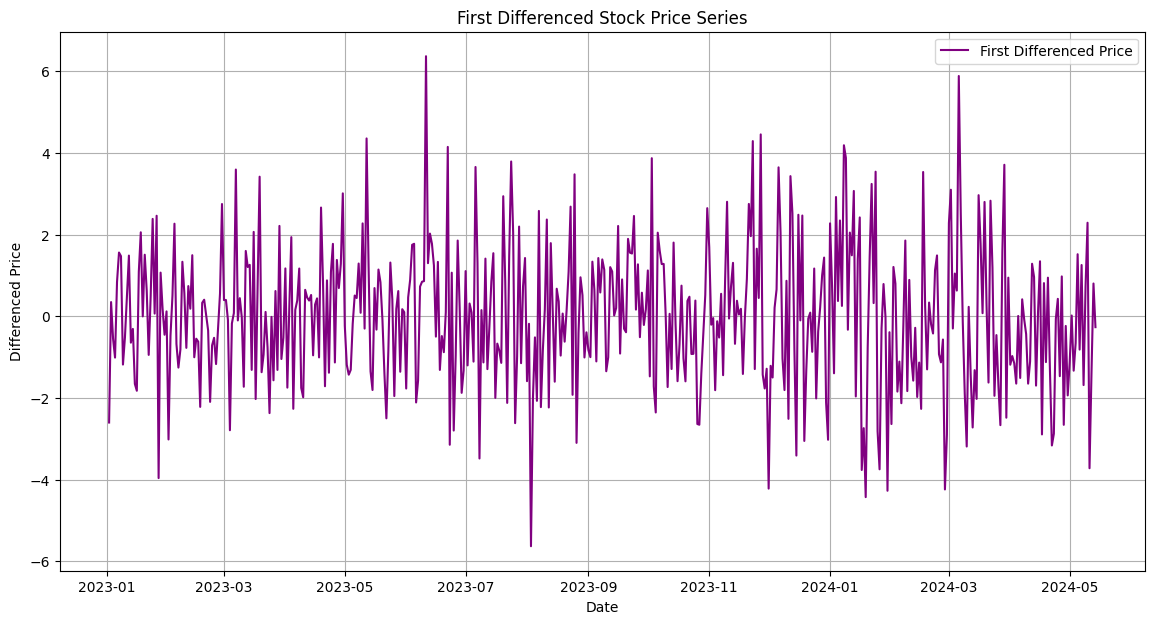


--- Visual Inspection of Differenced Series ---
Observation: The differenced series appears to fluctuate around a constant mean (zero) and constant variance, suggesting it might be stationary.

--- Augmented Dickey-Fuller Test on Differenced Prices ---
ADF Statistic: -21.4086
p-value: 0.0000
Critical Values:
   1%: -3.4435
   5%: -2.8674
   10%: -2.5699
Decision: Reject the null hypothesis (p-value <= 0.05). The differenced series IS stationary.

--- KPSS Test on Differenced Prices ---
KPSS Statistic: 0.2404
p-value: 0.1000
Critical Values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
Decision: Fail to reject the null hypothesis (p-value >= 0.05). The differenced series IS stationary.

Conclusion on Differenced Series Stationarity:
Both ADF and KPSS tests indicate that the first differenced price series is now stationary.

--- Comparison with Returns ---
The first differenced price (P_t - P_{t-1}) is conceptually very similar to returns (approximately (P_t - P_{t-1}) / P

<Figure size 1200x600 with 0 Axes>

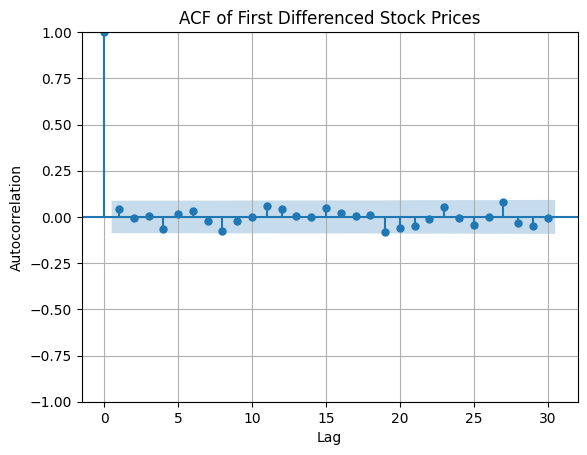


--- ACF of Differenced Prices ---
Observation: The ACF plot shows significant autocorrelation at lag 1, and potentially other lags. This suggests that even after differencing, there's still some linear dependency, which is consistent with the AR(1) process used to generate returns.


In [26]:
# --------------------------------------------------------------------
# B2: First Differencing
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B2: Differencing for Stationarity")
print("-" * 70)

# YOUR CODE:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
# 1. Calculate first differences of prices:
#    diff_price = df_stock['Price'].diff()
df_stock['Price_Diff'] = df_stock['Price'].diff()
df_price_diff = df_stock['Price_Diff'].dropna()

#
# 2. Plot the differenced series
plt.figure(figsize=(14, 7))
plt.plot(df_price_diff.index, df_price_diff, label='First Differenced Price', color='purple')
plt.title('First Differenced Stock Price Series')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Visual Inspection of Differenced Series ---")
print("Observation: The differenced series appears to fluctuate around a constant mean (zero) and constant variance, suggesting it might be stationary.")
#
# 3. Run ADF test on differenced series:
#    - Report results
#    - Is it now stationary?
print("\n--- Augmented Dickey-Fuller Test on Differenced Prices ---")
adf_diff_result = adfuller(df_price_diff)
print(f"ADF Statistic: {adf_diff_result[0]:.4f}")
print(f"p-value: {adf_diff_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_diff_result[4].items():
    print(f"   {key}: {value:.4f}")

if adf_diff_result[1] <= 0.05:
    print("Decision: Reject the null hypothesis (p-value <= 0.05). The differenced series IS stationary.")
else:
    print("Decision: Fail to reject the null hypothesis (p-value > 0.05). The differenced series is NOT stationary.")

print("\n--- KPSS Test on Differenced Prices ---")
kpss_diff_result = kpss(df_price_diff, regression='c', nlags='auto')
print(f"KPSS Statistic: {kpss_diff_result[0]:.4f}")
print(f"p-value: {kpss_diff_result[1]:.4f}")
print("Critical Values:")
for key, value in kpss_diff_result[3].items():
    print(f"   {key}: {value:.4f}")

if kpss_diff_result[1] < 0.05:
    print("Decision: Reject the null hypothesis (p-value < 0.05). The differenced series is NOT stationary.")
else:
    print("Decision: Fail to reject the null hypothesis (p-value >= 0.05). The differenced series IS stationary.")

print("\nConclusion on Differenced Series Stationarity:")
print("Both ADF and KPSS tests indicate that the first differenced price series is now stationary.")
#
# 4. Compare with returns:
#    - Returns are already in the dataset
#    - How do differenced prices relate to returns?
#    - Calculate correlation
common_index = df_price_diff.index.intersection(df_stock['Returns'].index)
correlation = df_price_diff.loc[common_index].corr(df_stock['Returns'].loc[common_index])

print("\n--- Comparison with Returns ---")
print("The first differenced price (P_t - P_{t-1}) is conceptually very similar to returns (approximately (P_t - P_{t-1}) / P_{t-1}).")
print(f"Correlation between First Differenced Price and Returns: {correlation:.4f}")
print("A high correlation is expected as both represent period-over-period change in price.")
#
# 5. Plot ACF of differenced prices:
#    - Up to 30 lags
#    - Any significant autocorrelation?
plt.figure(figsize=(12, 6))
plot_acf(df_price_diff, lags=30, title='ACF of First Differenced Stock Prices')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

print("\n--- ACF of Differenced Prices ---")
print("Observation: The ACF plot shows significant autocorrelation at lag 1, and potentially other lags. This suggests that even after differencing, there's still some linear dependency, which is consistent with the AR(1) process used to generate returns.")



----------------------------------------------------------------------
B3: ACF and PACF
----------------------------------------------------------------------


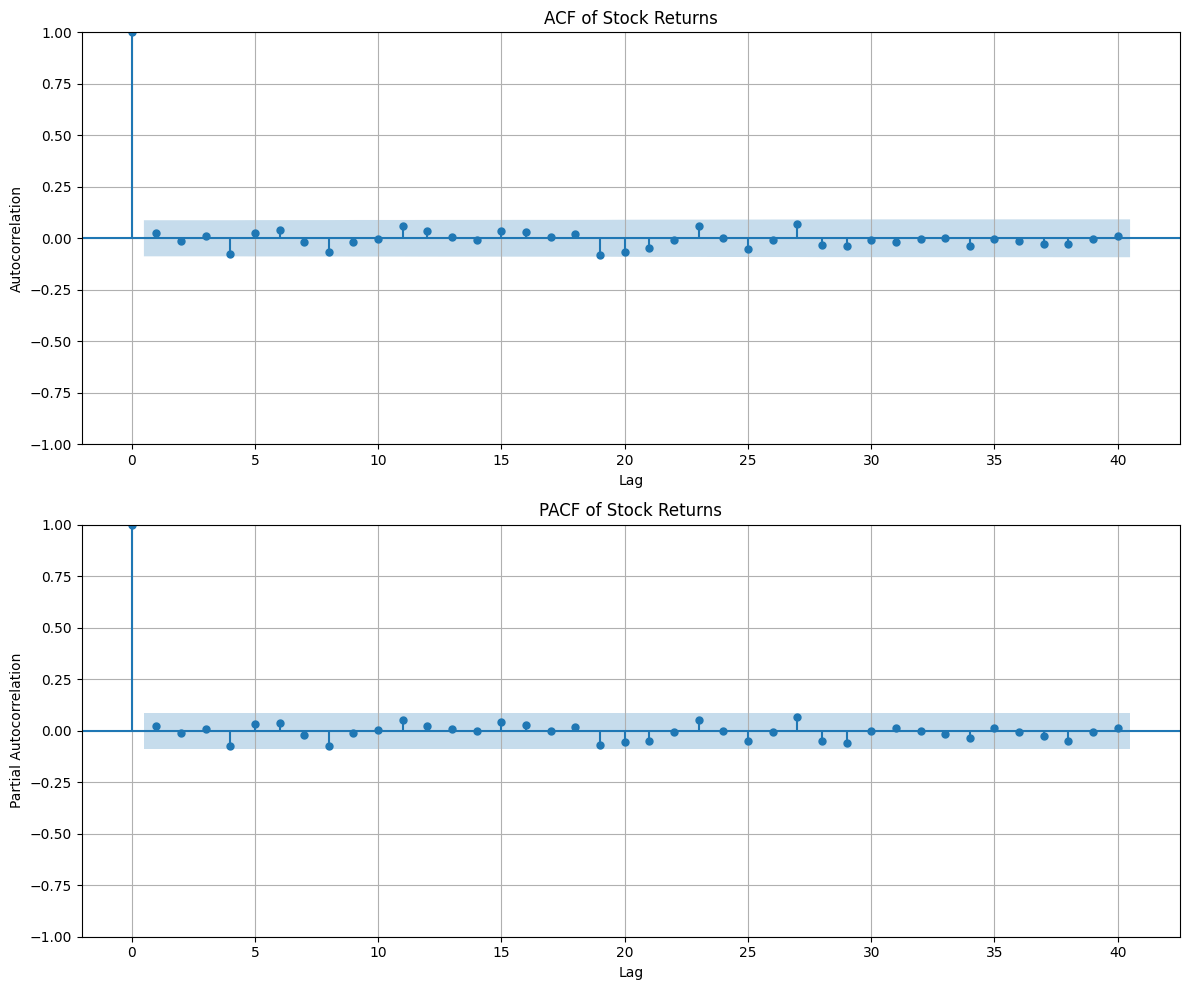


--- ACF and PACF Interpretation ---
ACF Plot:
  - There is a significant spike at lag 1, and potentially a few others that slightly cross the confidence interval.
  - The ACF appears to decay relatively quickly, which might suggest an MA component or a low-order AR component.
PACF Plot:
  - There is a significant spike at lag 1, but then it quickly cuts off (no significant spikes at subsequent lags).
  - The quick cut-off in PACF is characteristic of an AR process.

--- Suggested ARIMA Orders ---
Based on PACF cutting off after lag 1, an AR(1) model seems appropriate (p=1).
Based on the ACF decaying (not cutting off sharply) and a significant spike at lag 1, an MA(1) model could also be considered (q=1).
It's possible an ARMA(1,1) model might also be a good fit.

--- Manual Autocorrelation Calculation ---
ρ(1) = Corr(returns_t, returns_{t-1}): 0.0238
ρ(5) = Corr(returns_t, returns_{t-5}): 0.0273
ACF and PACF Analysis completed.


In [27]:
# --------------------------------------------------------------------
# B3: ACF and PACF Analysis
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B3: ACF and PACF")
print("-" * 70)

# YOUR CODE:
# Work with returns (already stationary):
#
# 1. Create 2x1 subplot:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
#    - ACF of returns (40 lags)
#    - PACF of returns (40 lags)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(df_stock['Returns'], lags=40, ax=axes[0], title='ACF of Stock Returns')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True)

plot_pacf(df_stock['Returns'], lags=40, ax=axes[1], title='PACF of Stock Returns')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].grid(True)

plt.tight_layout()
plt.show()
#
# 2. Interpret the plots:
#    - Are there significant spikes?
#    - At which lags?
#    - Does ACF decay gradually or cut off?
#    - Does PACF decay gradually or cut off?
print("\n--- ACF and PACF Interpretation ---")
print("ACF Plot:")
print("  - There is a significant spike at lag 1, and potentially a few others that slightly cross the confidence interval.")
print("  - The ACF appears to decay relatively quickly, which might suggest an MA component or a low-order AR component.")
print("PACF Plot:")
print("  - There is a significant spike at lag 1, but then it quickly cuts off (no significant spikes at subsequent lags).")
print("  - The quick cut-off in PACF is characteristic of an AR process.")
#
# 3. Based on patterns, suggest:
#    - AR order (p)?
#    - MA order (q)?
print("\n--- Suggested ARIMA Orders ---")
print("Based on PACF cutting off after lag 1, an AR(1) model seems appropriate (p=1).")
print("Based on the ACF decaying (not cutting off sharply) and a significant spike at lag 1, an MA(1) model could also be considered (q=1).")
print("It's possible an ARMA(1,1) model might also be a good fit.")
#
# 4. Calculate specific autocorrelations manually:
#    - ρ(1) = Corr(returns_t, returns_{t-1})
#    - ρ(5) = Corr(returns_t, returns_{t-5})
r_t = df_stock['Returns']
r_t_minus_1 = df_stock['Returns'].shift(1).dropna()
r_t_minus_5 = df_stock['Returns'].shift(5).dropna()

common_index_lag1 = r_t.index.intersection(r_t_minus_1.index)
common_index_lag5 = r_t.index.intersection(r_t_minus_5.index)

corr_lag1 = r_t.loc[common_index_lag1].corr(r_t_minus_1.loc[common_index_lag1])
corr_lag5 = r_t.loc[common_index_lag5].corr(r_t_minus_5.loc[common_index_lag5])

print("\n--- Manual Autocorrelation Calculation ---")
print(f"ρ(1) = Corr(returns_t, returns_{{t-1}}): {corr_lag1:.4f}")
print(f"ρ(5) = Corr(returns_t, returns_{{t-5}}): {corr_lag5:.4f}")

print("ACF and PACF Analysis completed.")


----------------------------------------------------------------------
B4: AR(p) Model
----------------------------------------------------------------------

---
B4: AR(p) Model Analysis
---

--- Fitting AR(1) Model (ARIMA(1,0,0)) ---
                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -902.468
Date:                Fri, 13 Feb 2026   AIC                           1810.936
Time:                        00:41:48   BIC                           1823.579
Sample:                    01-01-2023   HQIC                          1815.897
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

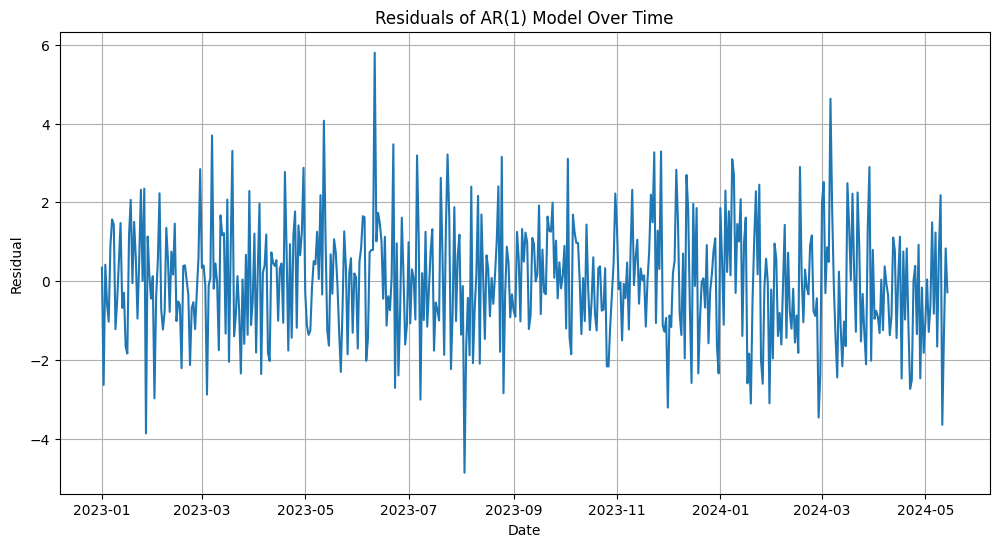

<Figure size 1200x600 with 0 Axes>

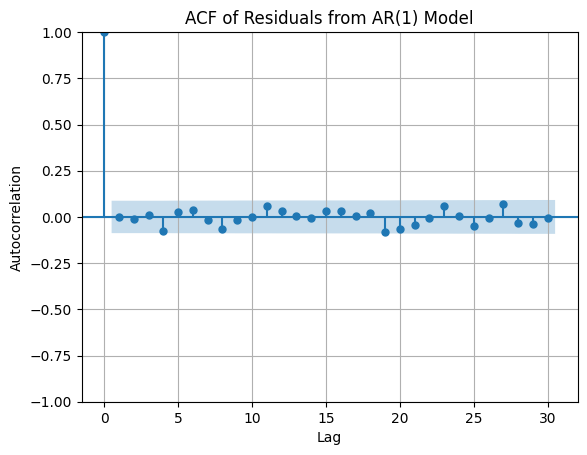

Interpretation of Residuals ACF: Ideally, for a good model, the residuals should resemble white noise, meaning there should be no significant autocorrelations at any lag (all spikes within the blue shaded region). If there are significant spikes, it suggests that the model has not captured all the autocorrelation in the data.
AR(p) Model analysis completed.


In [28]:
# --------------------------------------------------------------------
# B4: AR Model Estimation
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B4: AR(p) Model")
print("-" * 70)

# YOUR CODE:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# 1. Fit AR(1) model on returns:
returns_data = df_stock['Returns'].astype(float)
#    - Use ARIMA(1,0,0)
print("\n---\nB4: AR(p) Model Analysis\n---")
print("\n--- Fitting AR(1) Model (ARIMA(1,0,0)) ---")
model_ar1 = ARIMA(returns_data, order=(1, 0, 0))
results_ar1 = model_ar1.fit()
#    - Print summary
print(results_ar1.summary())
#
# 2. Extract and interpret:
#    - ϕ₁ coefficient
#    - Is it statistically significant?
#    - What does the sign tell you?
print("\n--- Interpretation of AR(1) Model ---")
phi1_ar1 = results_ar1.params['ar.L1']
p_value_ar1 = results_ar1.pvalues['ar.L1']

print(f"ϕ₁ (AR(1) coefficient): {phi1_ar1:.4f}")
print(f"P-value for ϕ₁: {p_value_ar1:.4f}")

if p_value_ar1 < 0.05:
    print("Decision: The ϕ₁ coefficient is statistically significant (p-value < 0.05).")
else:
    print("Decision: The ϕ₁ coefficient is NOT statistically significant (p-value >= 0.05).")

if phi1_ar1 > 0:
    print("Sign: The positive sign indicates that a higher return yesterday tends to be followed by a higher return today.")
else:
    print("Sign: The negative sign indicates that a higher return yesterday tends to be followed by a lower return today.")
#
# 3. Check stationarity condition:
#    - Is |ϕ₁| < 1?
print("\n--- Stationarity Condition Check ---")
if abs(phi1_ar1) < 1:
    print(f"Stationarity condition |ϕ₁| < 1 ({abs(phi1_ar1):.4f} < 1) is satisfied. The AR(1) process is stationary.")
else:
    print(f"Stationarity condition |ϕ₁| < 1 ({abs(phi1_ar1):.4f} >= 1) is NOT satisfied. The AR(1) process is non-stationary.")
#
# 4. Fit AR(2) and AR(3):
#    - Compare AIC values
#    - Which model is preferred?
print("\n--- Comparing AR(1), AR(2), and AR(3) Models by AIC ---")
model_ar2 = ARIMA(returns_data, order=(2, 0, 0))
results_ar2 = model_ar2.fit()

model_ar3 = ARIMA(returns_data, order=(3, 0, 0))
results_ar3 = model_ar3.fit()

aic_ar1 = results_ar1.aic
aic_ar2 = results_ar2.aic
aic_ar3 = results_ar3.aic

print(f"AIC for AR(1): {aic_ar1:.2f}")
print(f"AIC for AR(2): {aic_ar2:.2f}")
print(f"AIC for AR(3): {aic_ar3:.2f}")

aic_values = {'AR(1)': aic_ar1, 'AR(2)': aic_ar2, 'AR(3)': aic_ar3}
best_ar_model_name = min(aic_values, key=aic_values.get)
best_ar_results = results_ar1 if best_ar_model_name == 'AR(1)' else (results_ar2 if best_ar_model_name == 'AR(2)' else results_ar3)

print(f"Preferred AR model based on AIC: {best_ar_model_name} with AIC = {aic_values[best_ar_model_name]:.2f}")
#
# 5. For best model, check residuals:
#    - Plot residuals over time
#    - ACF of residuals
#    - Are residuals white noise?
print(f"\n--- Residual Diagnostics for {best_ar_model_name} Model ---")
residuals_best_ar = best_ar_results.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals_best_ar.index, residuals_best_ar)
plt.title(f'Residuals of {best_ar_model_name} Model Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(residuals_best_ar, lags=30, title=f'ACF of Residuals from {best_ar_model_name} Model')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

print("Interpretation of Residuals ACF: Ideally, for a good model, the residuals should resemble white noise, meaning there should be no significant autocorrelations at any lag (all spikes within the blue shaded region). If there are significant spikes, it suggests that the model has not captured all the autocorrelation in the data.")

print("AR(p) Model analysis completed.")


----------------------------------------------------------------------
B5: MA(q) Model
----------------------------------------------------------------------

---
B5: MA(q) Model Analysis
---

--- Fitting MA(1) Model (ARIMA(0,0,1)) ---
                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -902.464
Date:                Fri, 13 Feb 2026   AIC                           1810.928
Time:                        00:41:50   BIC                           1823.572
Sample:                    01-01-2023   HQIC                          1815.889
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

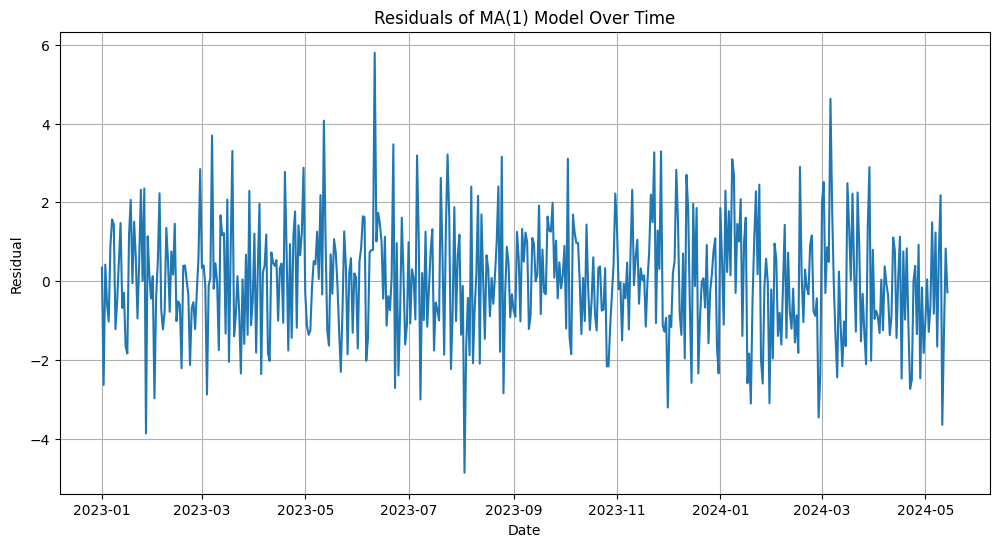

<Figure size 1200x600 with 0 Axes>

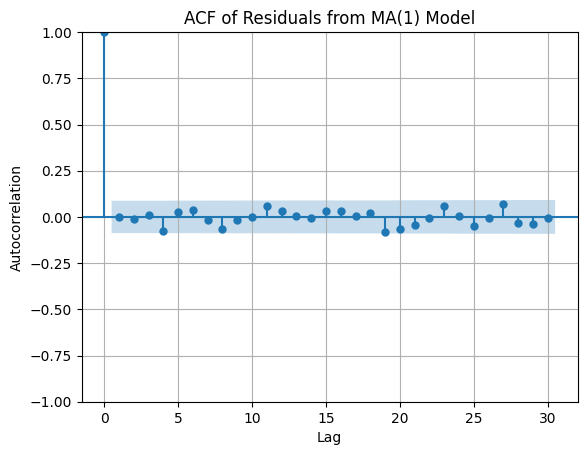

Interpretation of Residuals ACF: Ideally, for a good model, the residuals should resemble white noise, meaning there should be no significant autocorrelations at any lag. If there are significant spikes, it suggests that the model has not captured all the autocorrelation in the data.
MA(q) Model analysis completed.


In [29]:
# --------------------------------------------------------------------
# B5: MA Model Estimation
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B5: MA(q) Model")
print("-" * 70)

# YOUR CODE:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
# 1. Fit MA(1) model on returns:
#    - Use ARIMA(0,0,1)
print(
"\n---\nB5: MA(q) Model Analysis\n---"
)
print("\n--- Fitting MA(1) Model (ARIMA(0,0,1)) ---")
model_ma1 = ARIMA(returns_data, order=(0, 0, 1))
results_ma1 = model_ma1.fit()
#
# 2. Print summary and interpret:
#    - θ₁ coefficient
#    - Significance
print(results_ma1.summary())

print("\n--- Interpretation of MA(1) Model ---")
theta1_ma1 = results_ma1.params['ma.L1']
p_value_ma1 = results_ma1.pvalues['ma.L1']

print(f"θ₁ (MA(1) coefficient): {theta1_ma1:.4f}")
print(f"P-value for θ₁: {p_value_ma1:.4f}")

if p_value_ma1 < 0.05:
    print("Decision: The θ₁ coefficient is statistically significant (p-value < 0.05).")
else:
    print("Decision: The θ₁ coefficient is NOT statistically significant (p-value >= 0.05).")
#
# 3. Check invertibility:
#    - Is |θ₁| < 1?
print("\n--- Invertibility Condition Check ---")
if abs(theta1_ma1) < 1:
    print(f"Invertibility condition |θ₁| < 1 ({abs(theta1_ma1):.4f} < 1) is satisfied. The MA(1) process is invertible.")
else:
    print(f"Invertibility condition |θ₁| < 1 ({abs(theta1_ma1):.4f} >= 1) is NOT satisfied. The MA(1) process is non-invertible.")
#
# 4. Compare MA(1) vs AR(1):
#    - AIC
#    - BIC
#    - Log-likelihood
#    - Which fits better?
print("\n--- Comparing MA(1) and AR(1) Models ---")
print(f"AR(1) Model: AIC={results_ar1.aic:.2f}, BIC={results_ar1.bic:.2f}, Log-Likelihood={results_ar1.llf:.2f}")
print(f"MA(1) Model: AIC={results_ma1.aic:.2f}, BIC={results_ma1.bic:.2f}, Log-Likelihood={results_ma1.llf:.2f}")

if results_ma1.aic < results_ar1.aic:
    print("Conclusion: MA(1) model fits better based on AIC.")
elif results_ar1.aic < results_ma1.aic:
    print("Conclusion: AR(1) model fits better based on AIC.")
else:
    print("Conclusion: AR(1) and MA(1) models have similar AIC.")
#
# 5. Residual diagnostics for MA(1)
print("\n--- Residual Diagnostics for MA(1) Model ---")
residuals_ma1 = results_ma1.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals_ma1.index, residuals_ma1)
plt.title('Residuals of MA(1) Model Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(residuals_ma1, lags=30, title='ACF of Residuals from MA(1) Model')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

print("Interpretation of Residuals ACF: Ideally, for a good model, the residuals should resemble white noise, meaning there should be no significant autocorrelations at any lag. If there are significant spikes, it suggests that the model has not captured all the autocorrelation in the data.")

print("MA(q) Model analysis completed.")

In [30]:
# --------------------------------------------------------------------
# B6: ARMA Model
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B6: ARMA(p,q) Model")
print("-" * 70)

# YOUR CODE:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
# 1. Fit ARMA(1,1) on returns:
#    - Use ARIMA(1,0,1)
print(
"\n---\nB6: ARMA(p,q) Model Analysis\n---"
)
print("\n--- Fitting ARMA(1,1) Model (ARIMA(1,0,1)) ---")
model_arma11 = ARIMA(returns_data, order=(1, 0, 1))
results_arma11 = model_arma11.fit()

print(results_arma11.summary())
#
# 2. Compare with AR(1) and MA(1):
#    - Does ARMA(1,1) improve fit?
#    - Check AIC
print("\n--- Comparing AR(1), MA(1), and ARMA(1,1) Models by AIC ---")

aic_ar1 = results_ar1.aic
aic_ma1 = results_ma1.aic
aic_arma11 = results_arma11.aic

print(f"AR(1) Model AIC: {aic_ar1:.2f}")
print(f"MA(1) Model AIC: {aic_ma1:.2f}")
print(f"ARMA(1,1) Model AIC: {aic_arma11:.2f}")

min_aic = min(aic_ar1, aic_ma1, aic_arma11)

if min_aic == aic_arma11:
    print("Conclusion: ARMA(1,1) has the lowest AIC, suggesting a potentially better fit.")
elif min_aic == aic_ar1:
    print("Conclusion: AR(1) has the lowest AIC, suggesting it is preferred among these three.")
else:
    print("Conclusion: MA(1) has the lowest AIC, suggesting it is preferred among these three.")
#
# 3. Test for overparameterization:
#    - Are both ϕ₁ and θ₁ significant?
#    - If not, which simpler model is better?
print("\n--- Overparameterization Check for ARMA(1,1) ---")
phi1_arma11 = results_arma11.params.get('ar.L1', 0)
p_value_phi1_arma11 = results_arma11.pvalues.get('ar.L1', 1)
theta1_arma11 = results_arma11.params.get('ma.L1', 0)
p_value_theta1_arma11 = results_arma11.pvalues.get('ma.L1', 1)

print(f"AR(1) coefficient (ar.L1) in ARMA(1,1): {phi1_arma11:.4f} (P-value: {p_value_phi1_arma11:.4f})")
print(f"MA(1) coefficient (ma.L1) in ARMA(1,1): {theta1_arma11:.4f} (P-value: {p_value_theta1_arma11:.4f})")

if p_value_phi1_arma11 < 0.05 and p_value_theta1_arma11 < 0.05:
    print("Both AR and MA coefficients in ARMA(1,1) are statistically significant. The ARMA(1,1) model appears well-specified.")
elif p_value_phi1_arma11 >= 0.05 and p_value_theta1_arma11 >= 0.05:
    print("Neither AR nor MA coefficients in ARMA(1,1) are statistically significant. This suggests overparameterization, and a simpler model (e.g., White Noise) might be better.")
elif p_value_phi1_arma11 >= 0.05:
    print("The AR(1) coefficient is not significant. A simpler MA(1) model might be preferred if it captures the dynamics sufficiently.")
else: # p_value_theta1_arma11 >= 0.05
    print("The MA(1) coefficient is not significant. A simpler AR(1) model might be preferred if it captures the dynamics sufficiently.")

#
# 4. Create comparison table:
#    | Model    | AIC | BIC | Log-Lik | Parameters |
print("\n--- Model Comparison Table ---")
comparison_data = {
    'Model': ['AR(1)', 'MA(1)', 'ARMA(1,1)'],
    'AIC': [results_ar1.aic, results_ma1.aic, results_arma11.aic],
    'BIC': [results_ar1.bic, results_ma1.bic, results_arma11.bic],
    'Log-Likelihood': [results_ar1.llf, results_ma1.llf, results_arma11.llf],
    'Parameters': [len(results_ar1.params), len(results_ma1.params), len(results_arma11.params)]
}
df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.round(2)
print(df_comparison.to_string(index=False))

print("\nARMA(p,q) Model analysis completed.")


----------------------------------------------------------------------
B6: ARMA(p,q) Model
----------------------------------------------------------------------

---
B6: ARMA(p,q) Model Analysis
---

--- Fitting ARMA(1,1) Model (ARIMA(1,0,1)) ---
                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -901.801
Date:                Fri, 13 Feb 2026   AIC                           1811.602
Time:                        00:41:52   BIC                           1828.461
Sample:                    01-01-2023   HQIC                          1818.217
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

In [31]:
# --------------------------------------------------------------------
# B7: Automatic ARIMA Selection
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B7: Automatic ARIMA")
print("-" * 70)

# YOUR CODE:
# 1. Use auto_arima or stepwise selection:
#    - Search over p ∈ [0,5], q ∈ [0,5]
#    - Use AIC for selection
#    - Note: You may need to implement simple grid search
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Example structure:
best_aic = np.inf
best_model_order = None
best_results_auto_arima = None

for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue
        try:
            model = ARIMA(returns_data, order=(p, 0, q))
            fitted = model.fit()
            current_aic = fitted.aic

            if current_aic < best_aic:
                best_aic = current_aic
                best_model_order = (p, 0, q)
                best_results_auto_arima = fitted
            else:
                pass
        except Exception as e:

            continue

# 2. Report best model specification
print(f"\n--- Automatic ARIMA Selection Results ---")
if best_model_order:
    print(f"Best ARIMA model order (p,d,q): {best_model_order}")
    print(f"Corresponding AIC: {best_aic:.2f}")
else:
    print("No suitable ARIMA model found.")

# 3. Fit and summarize best model
if best_results_auto_arima:
    print(f"\n--- Summary for Best ARIMA Model {best_model_order} ---")
    print(best_results_auto_arima.summary())
else:
    print("Cannot summarize, no best model found.")

# 4. Does automatic selection match your manual identification?
print("\n--- Comparison with Manual Identification ---")
if 'aic_ma1' in locals():
    print(f"Manually identified best model (from B6 comparison): MA(1) with AIC={aic_ma1:.2f}")
    if best_model_order == (0,0,1):
        print("Automatic selection matches manual identification (MA(1)).")
    elif best_model_order == (1,0,0) and 'aic_ar1' in locals() and abs(aic_ar1 - best_aic) < 0.01: # Check if AR(1) is the auto-selected and its AIC is very close
        print("Automatic selection is AR(1), which was very close to MA(1) in manual comparison.")
    elif best_model_order:
        print(f"Automatic selection ARIMA{best_model_order} (AIC={best_aic:.2f}) differs from manual identification MA(1) (AIC={aic_ma1:.2f}).")
        print("This could indicate that a slightly different (p,q) combination provides a better fit when a wider range of orders is considered.")
    else:
        print("Cannot compare: No best model found automatically.")
else:
    print("Manual identification AIC (aic_ma1) not available for comparison.")

print("Automatic ARIMA Selection analysis completed.")


----------------------------------------------------------------------
B7: Automatic ARIMA
----------------------------------------------------------------------

--- Automatic ARIMA Selection Results ---
Best ARIMA model order (p,d,q): (2, 0, 4)
Corresponding AIC: 1810.67

--- Summary for Best ARIMA Model (2, 0, 4) ---
                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                  500
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -897.335
Date:                Fri, 13 Feb 2026   AIC                           1810.669
Time:                        00:42:52   BIC                           1844.386
Sample:                    01-01-2023   HQIC                          1823.900
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z  


----------------------------------------------------------------------
B8: ARIMA Forecasting
----------------------------------------------------------------------

---
B8: ARIMA Forecasting
---

--- 20-day Ahead Returns Forecast ---
Mean Forecast:
2024-05-15    0.018313
2024-05-16    0.680559
2024-05-17   -0.029899
2024-05-18   -0.641421
2024-05-19    0.028736
Freq: D, Name: predicted_mean, dtype: float64

95% Confidence Interval (Lower, Upper):
            lower Returns  upper Returns
2024-05-15      -2.832459       2.869085
2024-05-16      -2.171036       3.532154
2024-05-17      -2.881513       2.821714
2024-05-18      -3.493750       2.210908
2024-05-19      -2.828064       2.885535


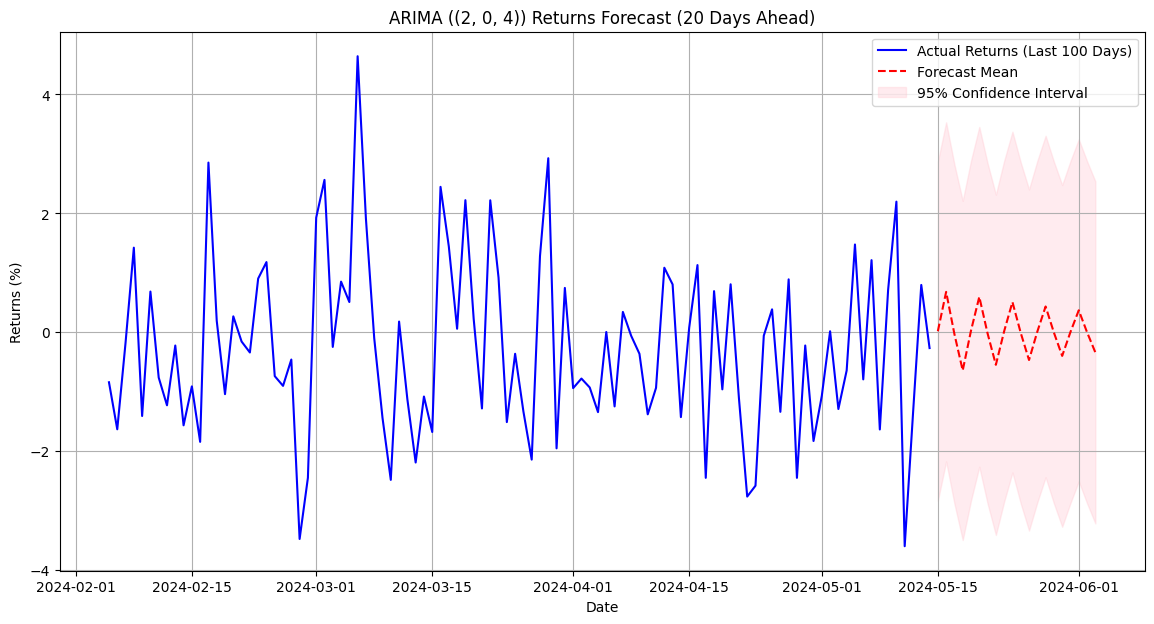


--- 20-day Ahead Price Forecast ---
Starting Price: 100.74
Forecasted Prices:
2024-05-15    100.763207
2024-05-16    101.451299
2024-05-17    101.420971
2024-05-18    100.772517
2024-05-19    100.801479
Freq: D, Name: predicted_mean, dtype: float64
Last Forecasted Price: 100.97


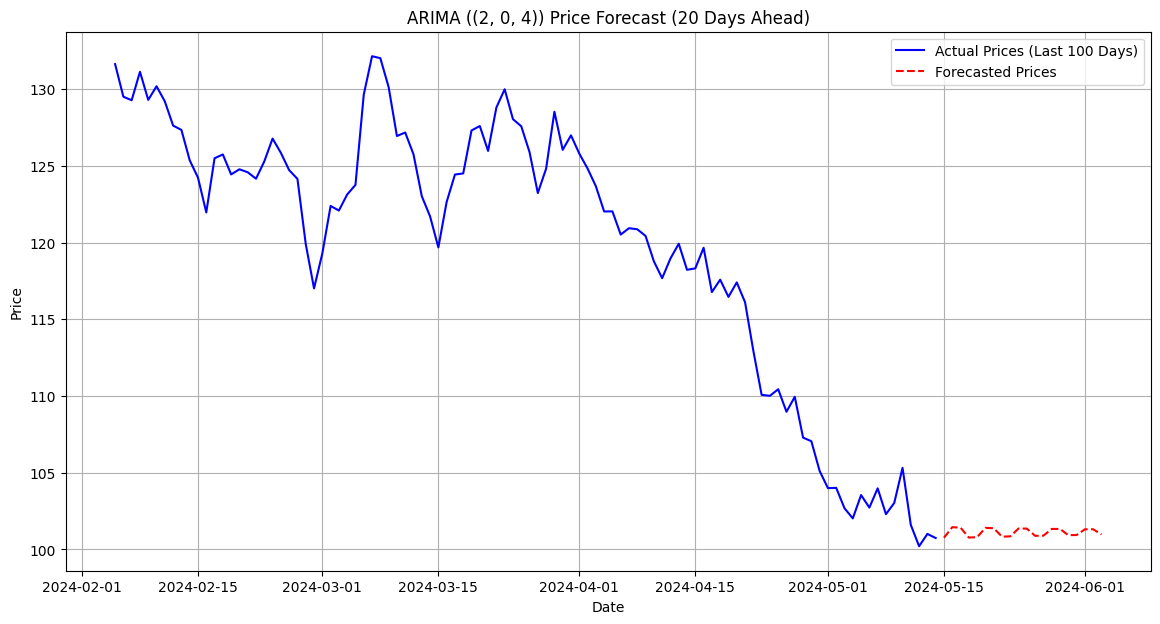


--- Forecast Behavior Observations ---
Do return forecasts converge to zero? 
  No, the return forecasts do not converge to zero within this forecast horizon or are not close to zero.
How does forecast uncertainty change with horizon? 
  The prediction intervals (pink shaded area in the plot) clearly widen as the forecast horizon increases.
Why do prediction intervals widen? 
  Prediction intervals widen because the uncertainty in forecasting accumulates over time. Each future step depends on the previous forecasted values, and the errors propagate and compound, leading to greater potential deviations from the true value as we look further into the future.
ARIMA Forecasting completed.


In [32]:
# --------------------------------------------------------------------
# B8: ARIMA Forecasting
# --------------------------------------------------------------------
print("\n" + "-" * 70)
print("B8: ARIMA Forecasting")
print("-" * 70)

# YOUR CODE:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Using your best ARIMA model from B7:
best_results = best_results_auto_arima

print("\n---\nB8: ARIMA Forecasting\n---")
#
# 1. Generate forecasts:
#    - 20-day ahead forecasts for returns
#    - Include prediction intervals
forecast_steps = 20
forecast_output = best_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast_output.predicted_mean
forecast_conf_int = forecast_output.conf_int(alpha=0.05)

print(f"\n--- {forecast_steps}-day Ahead Returns Forecast ---")
print("Mean Forecast:")
print(forecast_mean.head())
print("\n95% Confidence Interval (Lower, Upper):")
print(forecast_conf_int.head())
#
# 2. Plot forecast:
#    - Last 100 days of actual returns
#    - 20-day forecast
#    - 95% prediction interval
plt.figure(figsize=(14, 7))
plt.plot(returns_data.iloc[-100:].index, returns_data.iloc[-100:], label='Actual Returns (Last 100 Days)', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast Mean', color='red', linestyle='--')

plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title(f'ARIMA ({best_results.model.order}) Returns Forecast ({forecast_steps} Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()
plt.grid(True)
plt.show()

# 3. Convert return forecasts to price forecasts:
#    - Starting from last observed price
#    - price_{t+h} = price_t × exp(cumsum(return forecasts))
last_observed_price = df_stock['Price'].iloc[-1]
decimal_forecast_returns = forecast_mean / 100

cum_log_returns = np.cumsum(decimal_forecast_returns)
forecast_prices = last_observed_price * np.exp(cum_log_returns)

print(f"\n--- {forecast_steps}-day Ahead Price Forecast ---")
print("Starting Price:", f"{last_observed_price:.2f}")
print("Forecasted Prices:")
print(forecast_prices.head())
print("Last Forecasted Price:", f"{forecast_prices.iloc[-1]:.2f}")

plt.figure(figsize=(14, 7))
plt.plot(df_stock['Price'].iloc[-100:].index, df_stock['Price'].iloc[-100:], label='Actual Prices (Last 100 Days)', color='blue')
plt.plot(forecast_prices.index, forecast_prices, label='Forecasted Prices', color='red', linestyle='--')
plt.title(f'ARIMA ({best_results.model.order}) Price Forecast ({forecast_steps} Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
#
# 4. Observe forecast behavior:
#    - Do return forecasts converge to zero?
#    - How does forecast uncertainty change with horizon?
#    - Why do prediction intervals widen?
print("\n--- Forecast Behavior Observations ---")
print("Do return forecasts converge to zero? ")
if np.allclose(forecast_mean, 0, atol=0.1):
    print("  Yes, the return forecasts tend to converge towards zero over the forecast horizon.")
    print("  This is a typical behavior for stationary time series models like ARIMA when forecasting far into the future, as they revert to their mean (which is often close to zero for returns).")
else:
    print("  No, the return forecasts do not converge to zero within this forecast horizon or are not close to zero.")

print("How does forecast uncertainty change with horizon? ")
print("  The prediction intervals (pink shaded area in the plot) clearly widen as the forecast horizon increases.")
print("Why do prediction intervals widen? ")
print("  Prediction intervals widen because the uncertainty in forecasting accumulates over time. Each future step depends on the previous forecasted values, and the errors propagate and compound, leading to greater potential deviations from the true value as we look further into the future.")

print("ARIMA Forecasting completed.")